In [1]:
from statsbombpy import sb

wc_matches = sb.matches(competition_id=43, season_id=106)

wc_final = wc_matches[
    (wc_matches["home_team"] == "Argentina") |
    (wc_matches["away_team"] == "Argentina")
].sort_values("match_date")

wc_final[["match_id", "home_team", "away_team", "match_date"]]


c:\Users\Βασιλης\statsbomb_project\.venv\Lib\site-packages\statsbombpy\api_client.py:21: NoAuthWarning: credentials were not supplied. open data access only
  warnings.warn(


,match_id,home_team,away_team,match_date
37,3857300,Argentina,Saudi Arabia,2022-11-22
13,3857289,Argentina,Mexico,2022-11-26
11,3857264,Poland,Argentina,2022-11-30
1,3869151,Argentina,Australia,2022-12-03
6,3869321,Netherlands,Argentina,2022-12-09
19,3869519,Argentina,Croatia,2022-12-13
9,3869685,Argentina,France,2022-12-18


In [ ]:
final_match_id = 3869685
events_final = sb.events(match_id=final_match_id)
events_final.shape

In [56]:
lineups = sb.lineups(match_id=final_match_id)

In [71]:
arg_lineup = lineups["France"]
arg_lineup.head()


,player_id,player_name,player_nickname,jersey_number,country,cards,positions
0,2972,Marcus Thuram,None,26,France,"[{'time': '86:24', 'card_type': 'Yellow Card',...","[{'position_id': 23, 'position': 'Center Forwa..."
1,3009,Kylian Mbappé Lottin,Kylian Mbappé,10,France,[],"[{'position_id': 21, 'position': 'Left Wing', ..."
2,3026,Adrien Rabiot,None,14,France,"[{'time': '54:12', 'card_type': 'Yellow Card',...","[{'position_id': 11, 'position': 'Left Defensi..."
3,3099,Hugo Lloris,None,1,France,[],"[{'position_id': 1, 'position': 'Goalkeeper', ..."
4,3379,Alphonse Areola,None,23,France,[],[]


In [72]:
shirt_map = (
    arg_lineup[["player_name", "jersey_number"]]
    .set_index("player_name")["jersey_number"]
    .to_dict()
)


In [3]:
passes = events_final[
    (events_final["type"] == "Pass") &
    (events_final["pass_outcome"].isna())
]


Passing network

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [55]:
from mplsoccer import Pitch
import ast

Last try

In [66]:
TEAM = "France"

passes = events_final[
    (events_final["type"] == "Pass") &
    (events_final["team"] == TEAM) &
    (events_final["pass_outcome"].isna())
].copy()

passes.shape


(434, 94)

In [67]:
def to_xy(v):
    if isinstance(v, (list, tuple)) and len(v) >= 2:
        return v[0], v[1]
    if isinstance(v, str):
        try:
            vv = ast.literal_eval(v)
            if isinstance(vv, (list, tuple)) and len(vv) >= 2:
                return vv[0], vv[1]
        except Exception:
            pass
    return np.nan, np.nan


In [68]:
passes[["x", "y"]] = passes["location"].apply(lambda v: pd.Series(to_xy(v)))
passes[["end_x", "end_y"]] = passes["pass_end_location"].apply(lambda v: pd.Series(to_xy(v)))

passes = passes.dropna(
    subset=["x", "y", "end_x", "end_y", "player", "pass_recipient"]
)

passes.shape


(434, 98)

In [74]:
def pass_type_name(v):
    if isinstance(v, dict):
        return v.get("name")
    if isinstance(v, str):
        try:
            d = ast.literal_eval(v)
            if isinstance(d, dict):
                return d.get("name")
        except Exception:
            return v
        return v
    return None

passes["pass_type_name"] = passes["pass_type"].apply(pass_type_name)

SET_PIECES = {"Corner", "Free Kick", "Kick Off", "Throw-in", "Goal Kick"}

passes = passes[~passes["pass_type_name"].isin(SET_PIECES)].copy()
passes.shape


(384, 99)

In [75]:
player_pos = (
    passes
    .groupby("player")
    .agg(
        avg_x=("x", "mean"),
        avg_y=("y", "mean"),
        pass_count=("x", "count")
    )
    .reset_index()
)

# remove fringe players
MIN_PASSES = 10
player_pos = player_pos[player_pos["pass_count"] >= MIN_PASSES].copy()
player_pos.shape


(12, 4)

In [76]:
keep_players = set(player_pos["player"])

passes = passes[
    passes["player"].isin(keep_players) &
    passes["pass_recipient"].isin(keep_players)
].copy()


In [77]:
edges = (
    passes
    .groupby(["player", "pass_recipient"])
    .size()
    .reset_index(name="pass_count")
)

edges = edges[edges["pass_count"] >= 3].copy()
edges.sort_values("pass_count", ascending=False).head()


,player,pass_recipient,pass_count
85,Raphaël Varane,Dayotchanculle Upamecano,15
37,Dayotchanculle Upamecano,Raphaël Varane,14
59,Jules Koundé,Raphaël Varane,14
87,Raphaël Varane,Jules Koundé,12
20,Aurélien Djani Tchouaméni,Dayotchanculle Upamecano,9


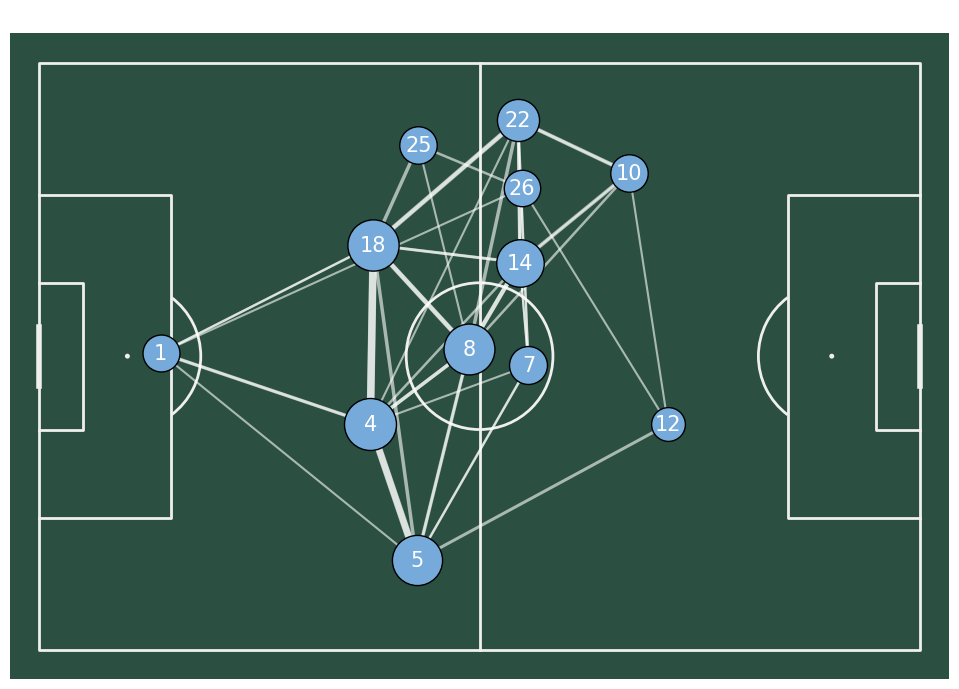

In [80]:
pitch = Pitch(
    pitch_type="statsbomb",
    pitch_color="#2b5041",
    line_color="#efefef"
)

fig, ax = pitch.draw(figsize=(11, 7))


pos_map = {
    r["player"]: (r["avg_x"], r["avg_y"])
    for _, r in player_pos.iterrows()
}

max_edge = edges["pass_count"].max()

for _, r in edges.iterrows():
    p1, p2, w = r["player"], r["pass_recipient"], r["pass_count"]
    x1, y1 = pos_map[p1]
    x2, y2 = pos_map[p2]

    lw = 0.5 + 5 * (w / max_edge)

    pitch.lines(
        x1, y1, x2, y2,
        lw=lw,
        color="white",
        alpha=0.6,
        ax=ax
    )
max_node = player_pos["pass_count"].max()

for _, r in player_pos.iterrows():
    x, y = r["avg_x"], r["avg_y"]
    size = 400 + 1000 * (r["pass_count"] / max_node)

    pitch.scatter(
        x, y,
        s=size,
        color="#75AADB",
        edgecolors="black",
        linewidth=1,
        ax=ax,
        zorder=3
    )

    ax.text(
        x, y,
        shirt_map[r['player']],
        ha="center",
        va="center",
        fontsize=15,
        color="#FFFFFF",
        zorder=4
    )
    ax.set_title(
        "Argentina Passing Network — World Cup 2022 Final (Whole Match)",
        fontsize=16,
        color="white"
    )

